In [2]:
import matplotlib

import numpy as np
import seaborn as sns
import sys

import matplotlib.pyplot as plt

import hdbscan
from collections import Counter
from sklearn.decomposition import PCA

from numpy import random
from collections import defaultdict

sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha': 0.2, 's': 10, 'linewidths': 0}

%matplotlib inline

In [4]:
def draw_PCA(cur_f, black_points=None, cur_pca=None):
    if cur_pca is None:
        f_pca = PCA(n_components=2).fit(cur_f).transform(cur_f)
    else:
        f_pca = cur_pca

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=10, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=10, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(cur_f)))
    else:
        plt.title("%s points" % len(cur_f))
        

Нормализация методом Маши:

In [5]:
def normalize(M):
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

Данные для смеси 4 кишечных палочек в реальной пропорции. Выравнивали на референс не из данных.

In [128]:
r = np.genfromtxt("LICHeE_4ecoli_without_ref/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("LICHeE_4ecoli_without_ref/matrices/X_all", dtype=int, delimiter=' ')
print("%s sites" % len(r))

123340 sites


In [104]:
Ncut = 5
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]

Delete zero and almost zero profiles:
113135 remained


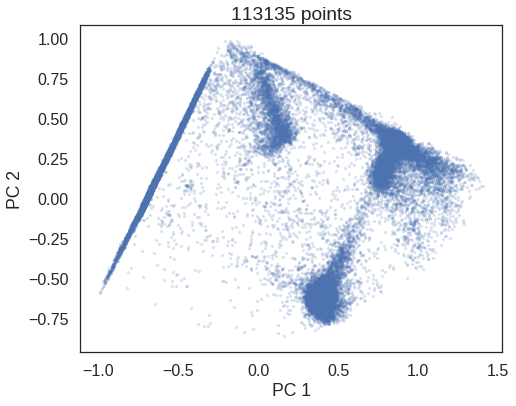

In [111]:
f = normalize(np.divide(x, r))
draw_PCA(f)

### Низкопокрытые образцы
А что, если нам мешают образцы, в которых низкое покрытие? Попробуем их удалить.

In [107]:
print(np.median(r, axis = 0))

[ 173.  250.   37.  207.  155.  172.   75.  245.  199.  284.  133.]


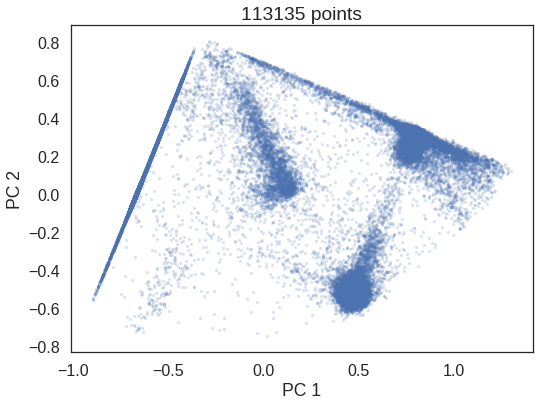

In [112]:
r_2 = np.delete(r, [2, 6], axis=1)
x_2 = np.delete(x, [2, 6], axis=1)
f_2 = normalize(np.divide(x_2, r_2))
draw_PCA(f_2)

Как видим, изменилось не много. Так что, оставим их в покое.

### Фильтрация по покрытию

In [113]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

Переберем персентили [25, 20, 15, 10] и количество плохих образцов от 0 до 3.

0 0-0 1-0 2-0 3-1 0-1 1-1 2-1 3-2 0-2 1-2 2-2 3-3 0-3 1-3 2-3 3-

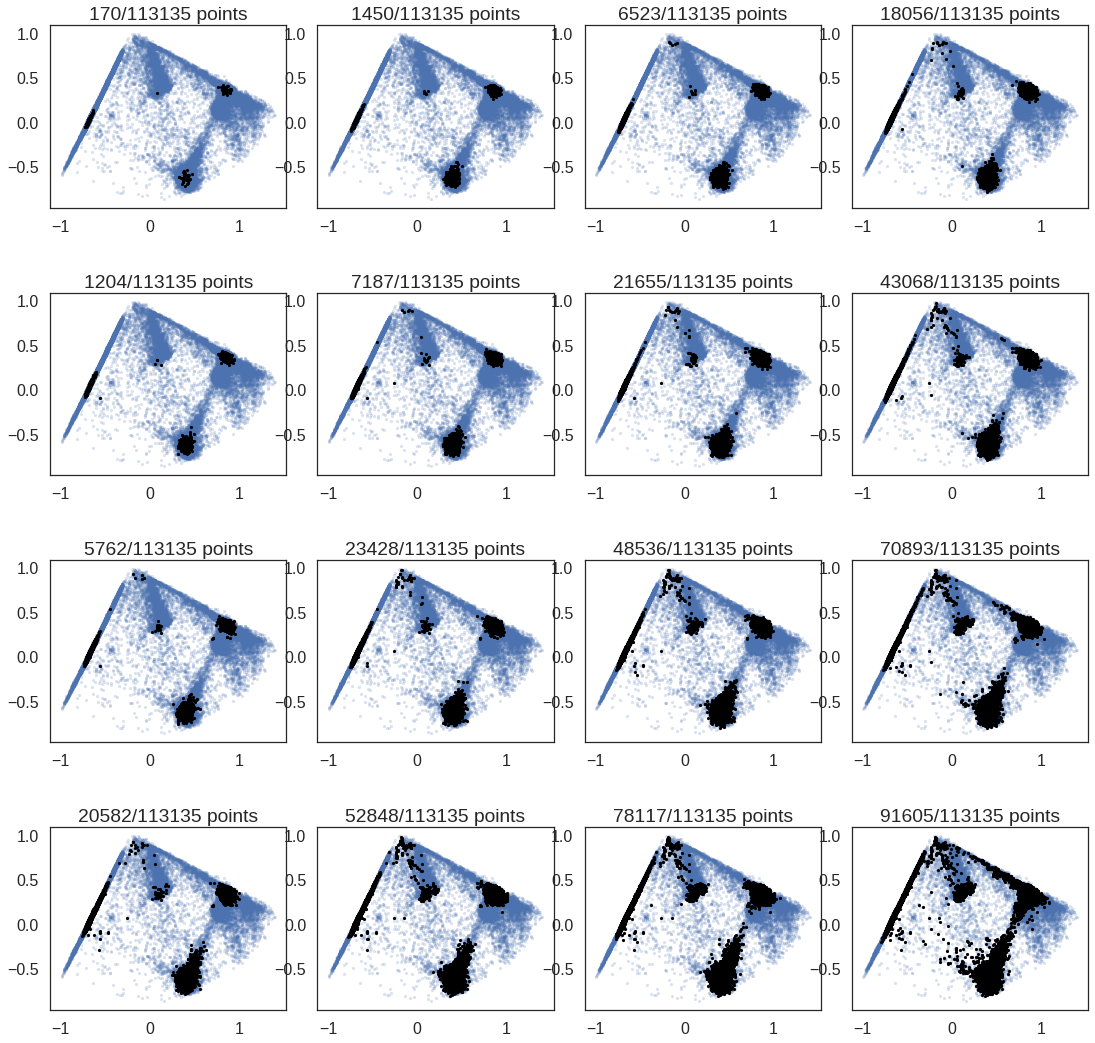

In [127]:
f_pca = PCA(n_components=2).fit(f).transform(f)

percentiles = [25, 20, 15, 10]
plt.figure(figsize=(15, 15))
for i in range(4):                                                         
    for j in range(4):
        print(i, j, end="-")
        plt.subplot(4, 4, i * 4 + j + 1)
        draw_PCA(f, filter_by_coverage(r, percentiles[i], j), f_pca)
                                                                                  
plt.tight_layout();